# check gpu

In [1]:
!gpustat

gpu3.datascience.usfca.edu  Thu Apr 27 14:13:03 2023  530.30.02
[0] NVIDIA TITAN RTX | 38°C,   0 % | 13877 / 24576 MB | ashrimal2(548M) cchavesbeltran(11488M)
[1] NVIDIA TITAN RTX | 27°C,   0 % |     5 / 24576 MB |
[2] NVIDIA TITAN RTX | 29°C,   0 % |     5 / 24576 MB |
[3] NVIDIA TITAN RTX | 28°C,   0 % |     5 / 24576 MB |
[4] NVIDIA TITAN RTX | 26°C,   0 % |     5 / 24576 MB |
[5] NVIDIA TITAN RTX | 29°C,   0 % |     5 / 24576 MB |
[6] NVIDIA TITAN RTX | 28°C,   0 % |     3 / 24576 MB |


In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
# run this cell if you need to specify a gpu
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# choose devices
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2"

# download dataset

To run this code, You need to install aicrowd-cli and login to aicrowd first<br>

`!pip install aicrowd-cli > /dev/null`<br>
`!aicrowd login`

In [7]:
!aicrowd login

Please login here: https://api.aicrowd.com/auth/aDFCjAK-_di7WBuJnH7cDrxTC7qkcGlJnLB6LJZQImU
/usr/bin/xdg-open: line 862: www-browser: command not found
/usr/bin/xdg-open: line 862: links2: command not found
)07                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [8]:
from fetch_data import *

# downloading this dataset will take 7-8 mins
fetch_data("food-recognition-benchmark-2022", "data")

The structure of your output directory will look like this:

In [9]:
!tree data -I '*.jpg|*.txt'

data
├── images
│   ├── test
│   ├── train
│   └── val
└── labels
    ├── train
    │   └── annotations.json
    └── val
        └── annotations.json

7 directories, 2 files


# convert annotations to yolo format

Since the annotations of this dataset are in COCO format, we need to convert them to the YOLO labeling format first for model training.

In [10]:
from convert_annotations import *

df_train = extract_info_from_json("data/labels/train/annotations.json")
df_val = extract_info_from_json("data/labels/val/annotations.json")

# for mode please choose bbox or segmentation
convert_to_yolov5(df_train, "data", split="train", mode="segmentation")
convert_to_yolov5(df_val, "data", split="val", mode="segmentation")

# check annotations

In [11]:
import random

path = "data/labels/val/"
file = random.choice(os.listdir(path))
file_path = os.path.join(path, file)

# print .txt file to check if all coords are between 0-1
with open(file_path, "r") as f:
    for line in f:
        print(line)

67 0.48724 0.94501 0.34694 0.93734 0.30612 0.91432 0.21939 0.83504 0.16964 0.76982 0.14923 0.711 0.14413 0.66496 0.14668 0.31969 0.15179 0.27877 0.18367 0.24425 0.28061 0.21867 0.58673 0.21867 0.64541 0.22634 0.70791 0.25831 0.72321 0.30946 0.72577 0.36829 0.71556 0.41944 0.71046 0.63427 0.68495 0.73913 0.64413 0.8133 0.5574 0.91049 0.52041 0.9399



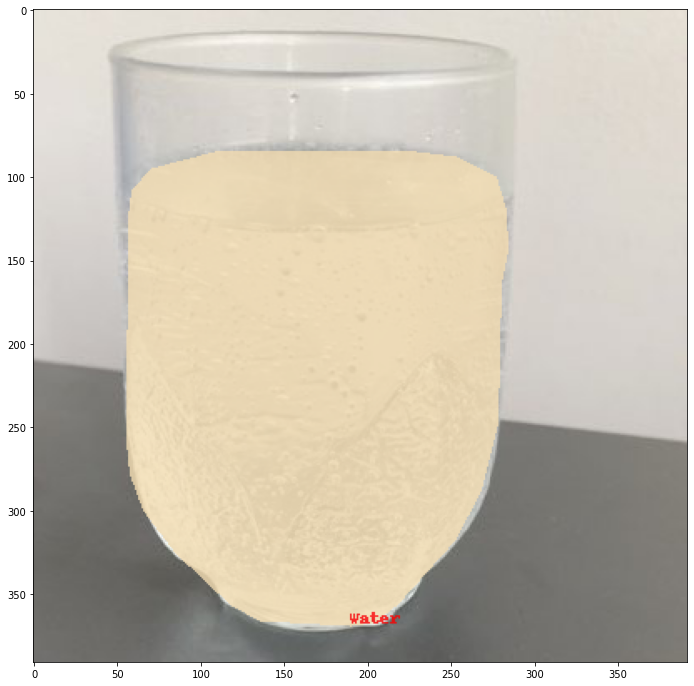

In [12]:
from convert_annotations import *

# for mode please choose bbox or segmentation
plot_annotations(file_path, mode="segmentation")

# Data Config File

Before creating data config file you need to download YOLOv5 first.<br>

`!git clone https://github.com/ultralytics/yolov5`<br>
`!pip install -r yolov5/requirements.txt`

In [13]:
from create_yaml import *

json_path = "data/labels/train/annotations.json"
output_path = "yolov5/data/food.yaml"

create_yaml(json_path, output_path)

# Experiment tracking setup

## ClearML

ClearML is completely integrated into YOLOv5 to track experimentation, manage dataset versions and even remotely execute training runs.
1. Install the clearml python package:<br>
`!pip install clearml`<br>
2. Connect the ClearML SDK to the server by creating credentials (https://app.clear.ml/settings/workspace-configuration), then execute the command below and follow the instructions:<br>
`!clearml-init`
3. Paste copied configuration:<br>
`%env CLEARML_WEB_HOST=https://app.clear.ml`<br>
`%env CLEARML_API_HOST=https://api.clear.ml`<br>
`%env CLEARML_FILES_HOST=https://files.clear.ml`<br>
`%env CLEARML_API_ACCESS_KEY=<Your Access Key>`<br>
`%env CLEARML_API_SECRET_KEY=<Your Secret Key>`<br>

Check tutorial: https://docs.ultralytics.com/yolov5/tutorials/clearml_logging_integration/#setting-things-up

## Comet

You need to install comet_ml and generate your API key first.<br>

`!pip install comet_ml --quiet`<br>
`!export COMET_API_KEY=<Your API KEY>`<br>

Check tutorial: https://colab.research.google.com/drive/1RG0WOQyxlDlo5Km8GogJpIEJlg_5lyYO?usp=sharing#scrollTo=dY_B24VQECQw

In [16]:
# !export COMET_API_KEY=y3vUzng8OE3o7feKQ2xAxNqgU

import comet_ml

comet_ml.init(project_name='Hakka')

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)


Comet API key:  ·························


COMET INFO: Valid Comet API Key saved in /home/ywang534/.comet.config (set COMET_CONFIG to change where it is saved).


# train

You need to download the models first.

`!wget -O yolov5m-seg.pt https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5m-seg.pt`<br>
or<br>
`!wget -O yolov5l-seg.pt https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5l-seg.pt`<br>

In [ ]:
# training each epoch takes about 30 mins

!python yolov5/segment/train.py \
 --project Hakka \
 --name yolo_food_det3 \
 --batch-size 32 \
 --img-size 640 \
 --epochs 3 \
 --data yolov5/data/food.yaml \
 --weights yolov5l-seg.pt

segment/train: weights=yolov5l-seg.pt, cfg=, data=yolov5/data/food.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=Hakka, name=yolo_food_det3, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, mask_ratio=4, no_overlap=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /home/ywang534/msds626/hakka/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-155-g8ecc727 Python-3.9.16 torch-2.0.0+cu117 CUDA:0 (NVIDIA TITAN RTX, 24212MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_

# inference

In [ ]:
!python yolov5/segment/predict.py \
--source data/images/test/ \
--weights yolov5/runs/train-seg/yolo_food_det3/weights/best.pt \
--conf 0.2 \
--name yolo_food_det3

# visualize

In [ ]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(file='path/to/results.csv', dir=''):
    # set context
    sns.set_context("notebook")
    sns.set_theme()
    # Plot training results.csv
    save_dir = Path(file).parent if file else Path(dir)
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)
    ax = ax.ravel()
    files = list(save_dir.glob('results*.csv'))
    assert len(files), f'No results.csv files found in {save_dir.resolve()}, nothing to plot.'
    for fi, f in enumerate(files):
        try:
            data = pd.read_csv(f)
            s = [x.strip() for x in data.columns]
            x = data.values[:, 0]
            for i, j in enumerate([1, 2, 3, 4, 5, 8, 9, 10, 6, 7]):
                y = data.values[:, j]
                # y[y == 0] = np.nan  # don't show zero values
                ax[i].plot(x, y, marker='.', label=f.stem, linewidth=2, markersize=8)
                ax[i].set_title(s[j], fontsize=12)
                # if j in [8, 9, 10]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except Exception as e:
            print(f'Warning: Plotting error for {f}: {e}')
    ax[1].legend()
#     fig.savefig(save_dir / 'results.png', dpi=200)
    plt.show()

In [ ]:
plot_results('yolov5/runs/train-seg/yolo_food_det3/results.csv')